<a href="https://colab.research.google.com/github/Ansalnakhan/Advanced-computing-lab/blob/main/RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir dataset
!cd dataset
!unzip /content/drive/MyDrive/naza.zip -d /content/dataset

mkdir: cannot create directory ‘dataset’: File exists
Archive:  /content/drive/MyDrive/naza.zip
replace /content/dataset/B0007.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#importing the necessary packages
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,TimeDistributed,LSTMCell
from tensorflow.keras.layers import Dropout,BatchNormalization,Bidirectional,MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Input

In [ ]:
#dataset preperation
def load_data(battery):
  mat = loadmat('./dataset/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]




In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<90)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=90)]
data_set_test=data_test.iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#created window of 10
for i in range(10,89):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


#LSTM

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 11s 235ms/step - loss: 0.1963 - root_mean_squared_error: 0.6266
Epoch 2/200
2/2 [==============================] - 0s 169ms/step - loss: 0.0899 - root_mean_squared_error: 0.4241
Epoch 3/200
2/2 [==============================] - 0s 195ms/step - loss: 0.0377 - root_mean_squared_error: 0.2746
Epoch 4/200
2/2 [==============================] - 1s 205ms/step - loss: 0.0244 - root_mean_squared_error: 0.2208
Epoch 5/200
2/2 [==============================] - 0s 226ms/step - loss: 0.0252 - root_mean_squared_error: 0.2243
Epoch 6/200
2/2 [==============================] - 0s 193ms/step - loss: 0.0398 - root_mean_squared_error: 0.2821
Epoch 7/200
2/2 [==============================] - 1s 284ms/step - loss: 0.0290 - root_mean_squared_error: 0.2410
Epoch 8/200
2/2 [==============================] - 0s 204ms/step - loss: 0.0151 - root_mean_squared_error: 0.1738
Epoch 9/200
2/2 [==============================] - 0s 199ms/step - loss: 0.0177 - root_

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)


In [ ]:
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.021
Mean Absolute Error:  [0.01557275]
R2_score:  0.92416860931125
    cycle  capacity  predicted
89     90  1.605819   1.509609
90     91  1.563849   1.505574
91     92  1.548092   1.502801
92     93  1.532376   1.500863
93     94  1.526953   1.500150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

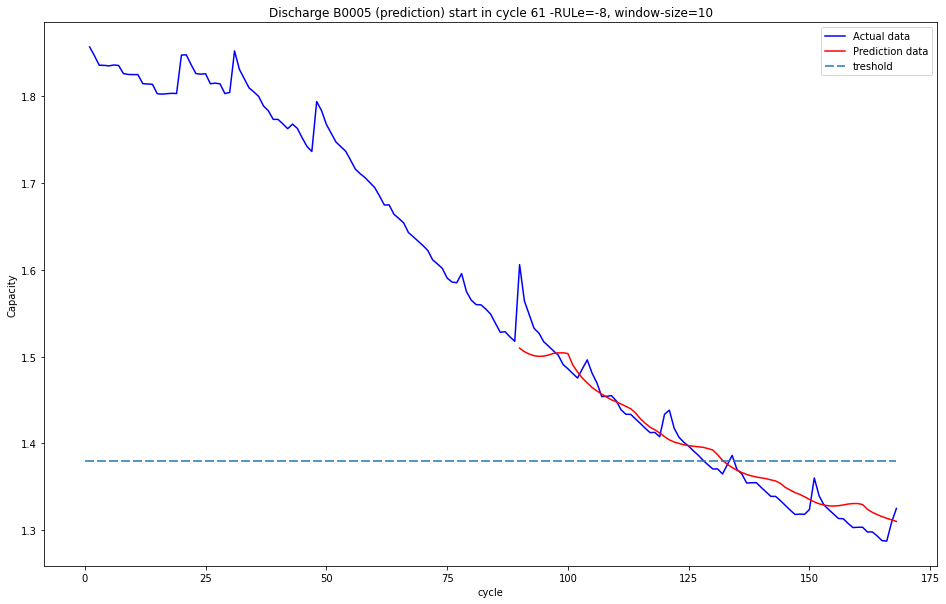

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# CNN-LSTM_DNN - Base

In [ ]:
model = Sequential()
#cnn with 64 neurons and kernel size 5 with padding and relu
model.add(Conv1D(64,5,padding="same",activation ="relu", input_shape=(X_train.shape[1],1)))
#lstm with same return sequences
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(Flatten())
#Fourth part DNN with 16 and 8 with relu activation
model.add(Dense(units=16,activation="relu"))
model.add(Dense(units=8,activation="relu"))
#final layer
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 10, 64)            384       
                                                                 
 lstm_28 (LSTM)              (None, 10, 32)            12416     
                                                                 
 lstm_29 (LSTM)              (None, 10, 32)            8320      
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_21 (Dense)            (None, 16)                5136      
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 5s 18ms/step - loss: 0.1944 - root_mean_squared_error: 0.6235
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1729 - root_mean_squared_error: 0.5880
Epoch 3/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1528 - root_mean_squared_error: 0.5528
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1271 - root_mean_squared_error: 0.5041
Epoch 5/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0994 - root_mean_squared_error: 0.4460
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0713 - root_mean_squared_error: 0.3776
Epoch 7/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0422 - root_mean_squared_error: 0.2905
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0178 - root_mean_squared_error: 0.1889
Epoch 9/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0086 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.140
Mean Absolute Error:  [0.12463215]
R2_score:  -2.3748431757676802
    cycle  capacity  predicted       pre
89     90  1.605819   1.521556  1.509609
90     91  1.563849   1.521295  1.505574
91     92  1.548092   1.521208  1.502801
92     93  1.532376   1.521179  1.500863
93     94  1.526953   1.521209  1.500150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

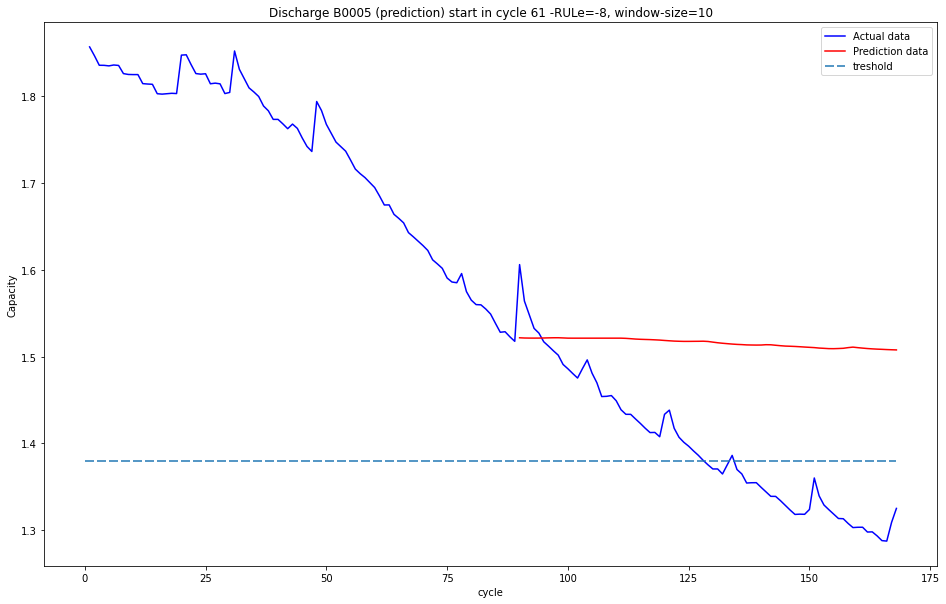

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# lstm+conv

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 10, 200)           161600    
                                                                 
 dropout_29 (Dropout)        (None, 10, 200)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 10, 32)            19232     
                                                                 
 lstm_42 (LSTM)              (None, 10, 200)           186400    
                                                                 
 dropout_30 (Dropout)        (None, 10, 200)           0         
                                                                 
 lstm_43 (LSTM)              (None, 10, 200)           320800    
                                                                 
 dropout_31 (Dropout)        (None, 10, 200)         

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 9s 133ms/step - loss: 0.2021 - root_mean_squared_error: 0.6357
Epoch 2/200
2/2 [==============================] - 0s 133ms/step - loss: 0.1178 - root_mean_squared_error: 0.4854
Epoch 3/200
2/2 [==============================] - 0s 146ms/step - loss: 0.0470 - root_mean_squared_error: 0.3065
Epoch 4/200
2/2 [==============================] - 0s 129ms/step - loss: 0.0350 - root_mean_squared_error: 0.2644
Epoch 5/200
2/2 [==============================] - 0s 146ms/step - loss: 0.0224 - root_mean_squared_error: 0.2114
Epoch 6/200
2/2 [==============================] - 0s 134ms/step - loss: 0.0426 - root_mean_squared_error: 0.2918
Epoch 7/200
2/2 [==============================] - 0s 131ms/step - loss: 0.0343 - root_mean_squared_error: 0.2619
Epoch 8/200
2/2 [==============================] - 0s 154ms/step - loss: 0.0180 - root_mean_squared_error: 0.1898
Epoch 9/200
2/2 [==============================] - 0s 136ms/step - loss: 0.0173 - root_m

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.021
Mean Absolute Error:  [0.01552387]
R2_score:  0.9265207810732146
    cycle  capacity  predicted       pre
89     90  1.605819   1.510029  1.516226
90     91  1.563849   1.506256  1.515444
91     92  1.548092   1.503326  1.515385
92     93  1.532376   1.500854  1.515870
93     94  1.526953   1.499462  1.516199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

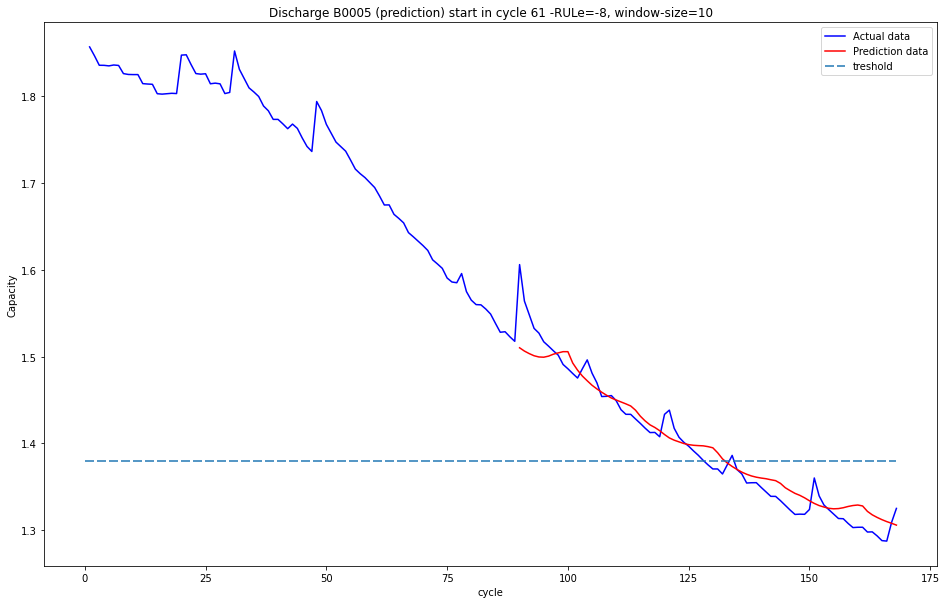

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#lstm+cnn+bilstm

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200)))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 200)           161600    
                                                                 
 dropout_8 (Dropout)         (None, 10, 200)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 32)            19232     
                                                                 
 bidirectional_10 (Bidirecti  (None, 10, 400)          372800    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 10, 400)           0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 10, 400)          961600    
 onal)                                                

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 13s 206ms/step - loss: 0.1991 - root_mean_squared_error: 0.6310
Epoch 2/200
2/2 [==============================] - 1s 204ms/step - loss: 0.0657 - root_mean_squared_error: 0.3626
Epoch 3/200
2/2 [==============================] - 0s 201ms/step - loss: 0.1308 - root_mean_squared_error: 0.5115
Epoch 4/200
2/2 [==============================] - 0s 202ms/step - loss: 0.0218 - root_mean_squared_error: 0.2090
Epoch 5/200
2/2 [==============================] - 0s 198ms/step - loss: 0.0631 - root_mean_squared_error: 0.3554
Epoch 6/200
2/2 [==============================] - 0s 201ms/step - loss: 0.0693 - root_mean_squared_error: 0.3722
Epoch 7/200
2/2 [==============================] - 0s 194ms/step - loss: 0.0490 - root_mean_squared_error: 0.3130
Epoch 8/200
2/2 [==============================] - 0s 199ms/step - loss: 0.0219 - root_mean_squared_error: 0.2093
Epoch 9/200
2/2 [==============================] - 0s 201ms/step - loss: 0.0192 - root_

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.021
Mean Absolute Error:  [0.01542871]
R2_score:  0.9259470502180821
    cycle  capacity  predicted
89     90  1.605819   1.508039
90     91  1.563849   1.505311
91     92  1.548092   1.504982
92     93  1.532376   1.505401
93     94  1.526953   1.506019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

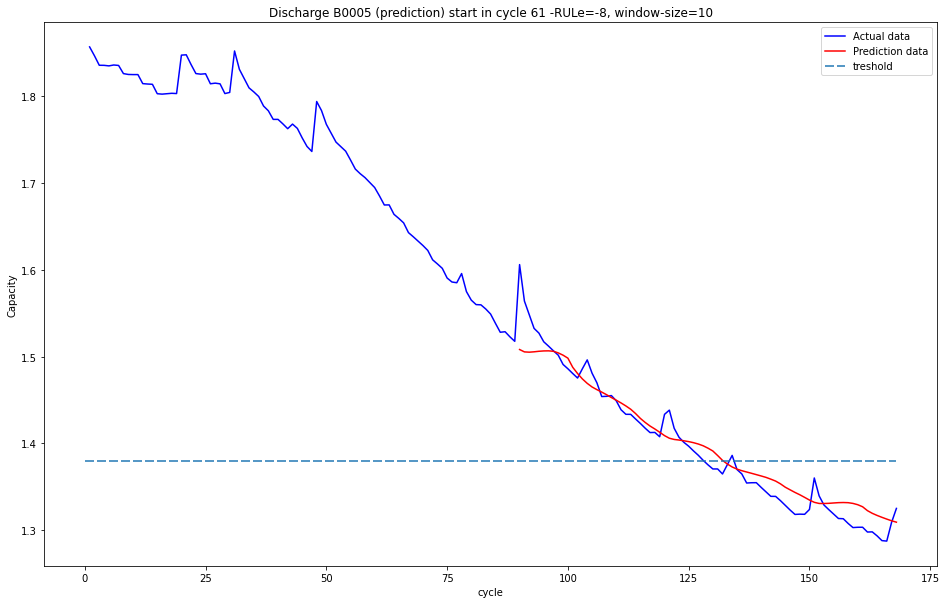

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# Conv +lstm + conv

In [ ]:

model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 10, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 lstm_25 (LSTM)              (None, 5, 100)            66000     
                                                                 
 dropout_21 (Dropout)        (None, 5, 100)            0         
                                                                 
 conv1d_18 (Conv1D)          (None, 5, 32)             9632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 32)            0         
 1D)                                                 

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 3s 12ms/step - loss: 0.2358 - root_mean_squared_error: 0.6868
Epoch 2/200
2/2 [==============================] - 0s 12ms/step - loss: 0.1554 - root_mean_squared_error: 0.5575
Epoch 3/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0868 - root_mean_squared_error: 0.4166
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0355 - root_mean_squared_error: 0.2663
Epoch 5/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0092 - root_mean_squared_error: 0.1358
Epoch 6/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0146 - root_mean_squared_error: 0.1707
Epoch 7/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0297 - root_mean_squared_error: 0.2436
Epoch 8/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0232 - root_mean_squared_error: 0.2153
Epoch 9/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0112 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.022
Mean Absolute Error:  [0.0168526]
R2_score:  0.9190986463120647
    cycle  capacity  predicted       pre
89     90  1.605819   1.510695  1.508039
90     91  1.563849   1.508653  1.505311
91     92  1.548092   1.510166  1.504982
92     93  1.532376   1.509179  1.505401
93     94  1.526953   1.512470  1.506019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

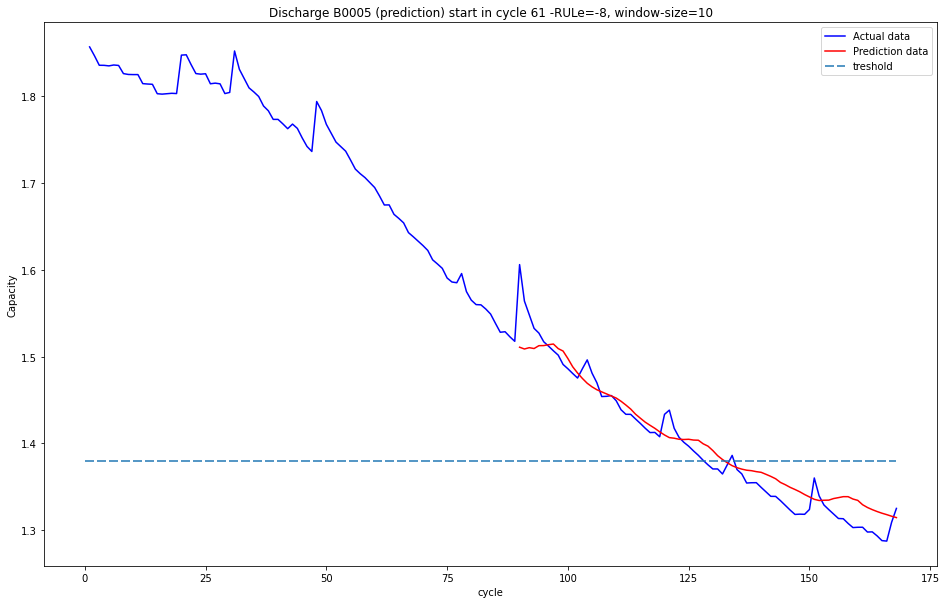

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# Conv +lstm + conv + dnn

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 10, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 lstm_27 (LSTM)              (None, 5, 100)            66000     
                                                                 
 dropout_23 (Dropout)        (None, 5, 100)            0         
                                                                 
 conv1d_22 (Conv1D)          (None, 5, 32)             9632      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 2, 32)            0         
 1D)                                                 

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 4s 14ms/step - loss: 0.3366 - root_mean_squared_error: 0.8236
Epoch 2/200
2/2 [==============================] - 0s 14ms/step - loss: 0.1694 - root_mean_squared_error: 0.5821
Epoch 3/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0581 - root_mean_squared_error: 0.3409
Epoch 4/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0135 - root_mean_squared_error: 0.1644
Epoch 5/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0255 - root_mean_squared_error: 0.2258
Epoch 6/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0423 - root_mean_squared_error: 0.2909
Epoch 7/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0300 - root_mean_squared_error: 0.2448
Epoch 8/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0130 - root_mean_squared_error: 0.1613
Epoch 9/200
2/2 [==============================] - 0s 12ms/step - loss: 0.0083 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.021
Mean Absolute Error:  [0.01550607]
R2_score:  0.9271956490110127
    cycle  capacity  predicted       pre
89     90  1.605819   1.510209  1.510695
90     91  1.563849   1.508010  1.508653
91     92  1.548092   1.508953  1.510166
92     93  1.532376   1.507920  1.509179
93     94  1.526953   1.508132  1.512470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

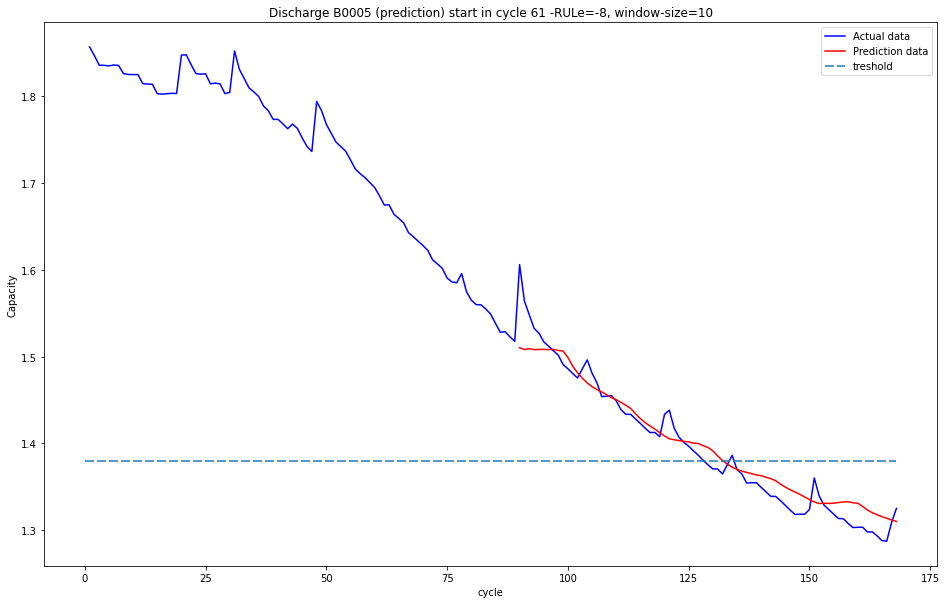

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#CNN_LSTM_DNN

In [ ]:
model = Sequential()
#cnn with 64 neurons and kernel size 5 with padding and relu
model.add(Conv1D(64,5,padding="same",input_shape=(X_train.shape[1],1)))
#lstm with same return sequences
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(Flatten())
#Fourth part DNN with 16 and 8 with relu activation
model.add(Dense(units=16))
model.add(Dense(units=8))
#final layer
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 10, 64)            384       
                                                                 
 lstm_29 (LSTM)              (None, 10, 32)            12416     
                                                                 
 lstm_30 (LSTM)              (None, 10, 32)            8320      
                                                                 
 flatten_7 (Flatten)         (None, 320)               0         
                                                                 
 dense_28 (Dense)            (None, 16)                5136      
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dense_30 (Dense)            (None, 1)               

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 4s 16ms/step - loss: 0.2410 - root_mean_squared_error: 0.6944
Epoch 2/200
2/2 [==============================] - 0s 14ms/step - loss: 0.1385 - root_mean_squared_error: 0.5263
Epoch 3/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0602 - root_mean_squared_error: 0.3470
Epoch 4/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0149 - root_mean_squared_error: 0.1725
Epoch 5/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0196 - root_mean_squared_error: 0.1981
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0385 - root_mean_squared_error: 0.2775
Epoch 7/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0255 - root_mean_squared_error: 0.2260
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0102 - root_mean_squared_error: 0.1426
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0100 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.033
Mean Absolute Error:  [0.02743809]
R2_score:  0.8113038094283547
    cycle  capacity  predicted       pre
89     90  1.605819   1.511752  1.510209
90     91  1.563849   1.511105  1.508010
91     92  1.548092   1.511377  1.508953
92     93  1.532376   1.512411  1.507920
93     94  1.526953   1.512923  1.508132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

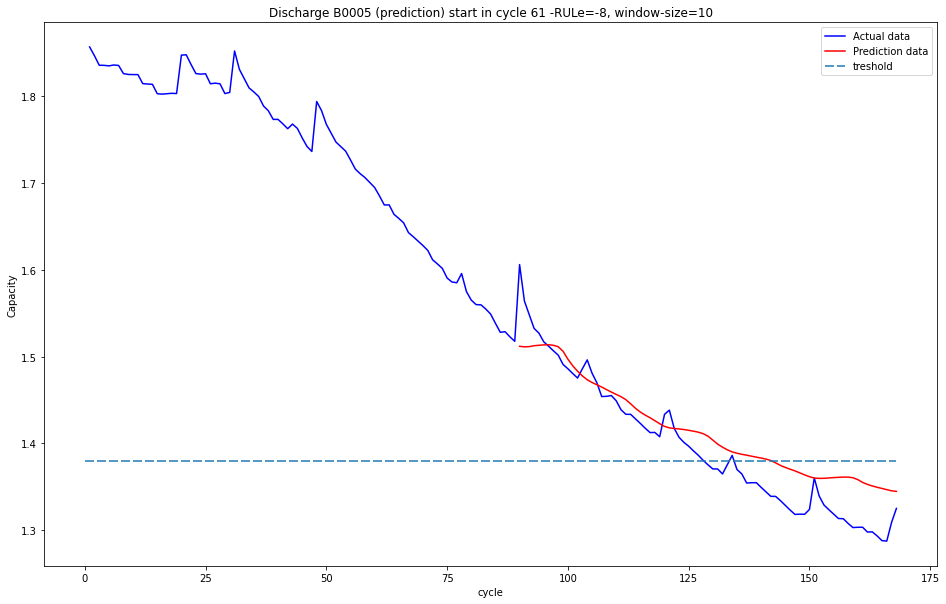

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#cnn+bilstm+dnn

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 10, 64)            256       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 5, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_22 (Bidirecti  (None, 5, 200)           132000    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 5, 200)            0         
                                                                 
 flatten_11 (Flatten)        (None, 1000)              0         
                                                                 
 dense_40 (Dense)            (None, 16)              

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 6s 29ms/step - loss: 0.1740 - root_mean_squared_error: 0.5899
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0311 - root_mean_squared_error: 0.2493
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0144 - root_mean_squared_error: 0.1698
Epoch 4/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0389 - root_mean_squared_error: 0.2788
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0213 - root_mean_squared_error: 0.2062
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0052 - root_mean_squared_error: 0.1019
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0059 - root_mean_squared_error: 0.1084
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0127 - root_mean_squared_error: 0.1596
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0144 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.026
Mean Absolute Error:  [0.02101729]
R2_score:  0.8864106341425242
    cycle  capacity  predicted       pre
89     90  1.605819   1.508654  1.511752
90     91  1.563849   1.526599  1.511105
91     92  1.548092   1.530590  1.511377
92     93  1.532376   1.524837  1.512411
93     94  1.526953   1.522765  1.512923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

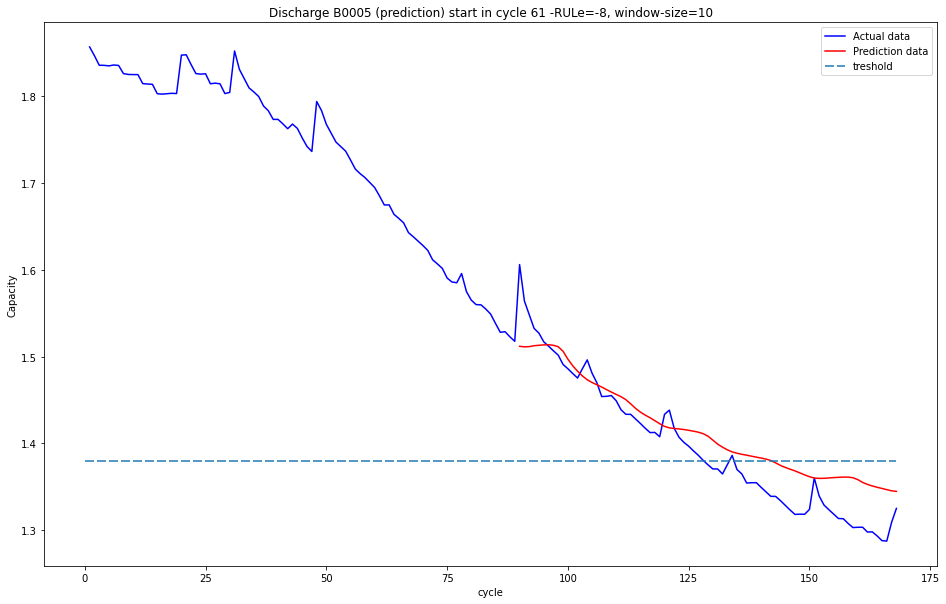

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')